###### Imports and Settings

In [11]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

###### Read in File  
Ensure everything is consistent from when writing it out in data prep notebook and it is ready for scikitlearn package.

In [3]:
df = gpd.read_file('../data/geo/ALLPLACES.shp')

In [4]:
df.head()

,GEOID,NAME,NAMELSAD,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,14permits,19permits,permreal,perm%,geometry
0,0115136,Clanton,Clanton city,22.84,01,15136,8689.0,8672.0,8700.0,2.44,31.1,0.32,28.0,0.13,11.0,Alabama,380.91,379.68,380.43,1.23,0.32,0.48,0.13,Clanton,13820,23.4,26.4,3.0,12.82,"POLYGON ((-86.68405 32.83101, -86.68383 32.831..."
1,0163336,Rainsville,Rainsville city,20.62,01,63336,4898.0,4984.0,5041.0,2.66,21.5,1.14,57.0,2.92,143.0,Alabama,244.47,241.71,237.54,2.76,1.14,6.93,2.92,Rainsville,99999,11.2,23.2,12.0,107.14,"POLYGON ((-85.89968 34.51085, -85.89943 34.511..."
2,0171976,Spanish Fort,Spanish Fort city,30.22,01,71976,6081.0,7357.0,8601.0,2.62,25.0,16.91,1244.0,41.44,2520.0,Alabama,284.61,243.45,201.22,41.16,16.91,83.39,41.44,Spanish Fort,19300,19.8,138.0,118.2,596.97,"MULTIPOLYGON (((-87.87776 30.73229, -87.87581 ..."
3,0171976,Spanish Fort,Spanish Fort city,30.22,01,71976,6081.0,7357.0,8601.0,2.62,25.0,16.91,1244.0,41.44,2520.0,Alabama,284.61,243.45,201.22,41.16,16.91,83.39,41.44,Spanish Fort,99999,46.2,0.0,-46.2,-100.00,"MULTIPOLYGON (((-87.87776 30.73229, -87.87581 ..."
4,0116768,Columbiana,Columbiana city,17.30,01,16768,3892.0,4198.0,4481.0,2.20,26.8,6.74,283.0,15.13,589.0,Alabama,259.02,242.66,224.97,16.36,6.74,34.05,15.14,Columbiana,13820,2.6,51.2,48.6,1869.23,"MULTIPOLYGON (((-86.56642 33.20085, -86.56641 ..."


In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       90 non-null     object  
 1   NAME        90 non-null     object  
 2   NAMELSAD    90 non-null     object  
 3   SQMILES     90 non-null     float64 
 4   StateFIPS   90 non-null     object  
 5   PlaceFIPS   90 non-null     object  
 6   09pop       90 non-null     float64 
 7   14pop       90 non-null     float64 
 8   19pop       90 non-null     float64 
 9   hhsize      90 non-null     float64 
 10  drive       90 non-null     float64 
 11  ST%         90 non-null     float64 
 12  ST          90 non-null     float64 
 13  LT%         90 non-null     float64 
 14  LT          90 non-null     float64 
 15  State       90 non-null     object  
 16  19density   90 non-null     float64 
 17  14density   90 non-null     float64 
 18  09density   90 non-null     float64 
 19  ST

Looks good. This is an index-ordered dataframe with multiple numeric columns containing no null or zero values, perfect for scikit learn and its k means clustering algorithm.

# Cluster Analyses

## 1. Variables:  

#### Step One: Set variables.

In [6]:
variables = df[['19pop','LT','LT%','LT%Density','ST%Density','19density','ST','ST%','hhsize','drive']]

#### Step Two: Use the elbow method to determine the proper number of clusters.  

This identifies the value of *k* where the distortion begins to decrease the most rapidly - this becomes clear when plotting the distortion for different values.

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


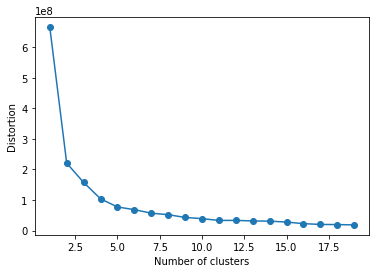

In [7]:
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(variables)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Observations: It looks like the distortion really starts to go down when you reach 7 clusters. Set this variable as your max to use later.

#### Step Three: Implement KMeans algorithm.  

Here you set the clusters to the number identified using the elbow method, and set parameters for the algorithm as outlined below.

In [8]:
km = KMeans(n_clusters = 7, #number of clusters
           init = 'k-means++', #k means ++ is a weighted method of choosing the first datapoint from which to start finding centroids from, versus choosing a random one
           n_init = 10, #run the k-means clustering algorithm 10x independently with random centroids to choose final model w/lowest SSE
           max_iter = 300, #maximum number of iterations for each single run, the implementation in scikit learn stops early if it converges before
           tol = 1e-04, #tolerance for changes in the within-cluster sum-squared error to declare convergence
           random_state = None)

#### Step Four: Use fit_predict to compute cluster centers and predict cluster index per each sample.

In [9]:
y_km = km.fit_predict(variables)
y_km

array([0, 1, 5, 5, 1, 0, 1, 1, 1, 6, 5, 2, 2, 0, 0, 0, 2, 2, 3, 6, 2, 1,
       1, 1, 1, 1, 3, 6, 3, 1, 6, 2, 1, 0, 1, 3, 0, 6, 3, 5, 4, 3, 2, 6,
       1, 6, 1, 6, 3, 0, 3, 1, 0, 2, 1, 2, 3, 0, 3, 2, 1, 5, 0, 6, 6, 0,
       0, 5, 1, 3, 3, 1, 6, 4, 0, 1, 2, 2, 1, 4, 3, 3, 4, 3, 0, 2, 3, 3,
       5, 2])

In [12]:
#See how many instances there are of each cluster id, there are five clusters so 4+1
count_arr = np.bincount(y_km)
for i in range(0, 6+1):
    print('Total occurences of {} in array: '.format(i), count_arr[i-1])

Total occurences of 0 in array:  11
Total occurences of 1 in array:  15
Total occurences of 2 in array:  22
Total occurences of 3 in array:  14
Total occurences of 4 in array:  17
Total occurences of 5 in array:  4
Total occurences of 6 in array:  7


#### Step Five: Assign cluster index as a new row to the df.

In [13]:
df['cluster'] = y_km

#### Step Seven: Identify Coopertown's cluster id.

In [14]:
CT = df.loc[df['GEOID'] == '4716980']
CT

,GEOID,NAME,NAMELSAD,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,14permits,19permits,permreal,perm%,geometry,cluster
75,4716980,Coopertown,Coopertown town,31.58,47,16980,3342.0,4321.0,4496.0,2.79,33.8,4.05,175.0,34.53,1154.0,Tennessee,142.37,136.83,105.83,5.54,4.05,36.54,34.53,Coopertown town,34980,6.0,21.8,15.8,263.33,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",1


#### Step Eight: Create a new dataframe with only peers based on this cluster id and examine.

In [15]:
CTCluster = df.loc[df['cluster'] == 1].reset_index(drop = True)
CTCluster.head(50)

,GEOID,NAME,NAMELSAD,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,14permits,19permits,permreal,perm%,geometry,cluster
0,0163336,Rainsville,Rainsville city,20.62,01,63336,4898.0,4984.0,5041.0,2.66,21.5,1.14,57.0,2.92,143.0,Alabama,244.47,241.71,237.54,2.76,1.14,6.93,2.92,Rainsville,99999,11.2,23.2,12.0,107.14,"POLYGON ((-85.89968 34.51085, -85.89943 34.511...",1
1,0116768,Columbiana,Columbiana city,17.30,01,16768,3892.0,4198.0,4481.0,2.20,26.8,6.74,283.0,15.13,589.0,Alabama,259.02,242.66,224.97,16.36,6.74,34.05,15.14,Columbiana,13820,2.6,51.2,48.6,1869.23,"MULTIPOLYGON (((-86.56642 33.20085, -86.56641 ...",1
2,0133856,Headland,Headland city,30.33,01,33856,3960.0,4637.0,4665.0,2.85,27.6,0.60,28.0,17.80,705.0,Alabama,153.81,152.88,130.56,0.93,0.61,23.25,17.81,Headland,20020,27.4,21.2,-6.2,-22.63,"POLYGON ((-85.41739 31.32953, -85.41734 31.333...",1
3,0182992,Winfield,Winfield city,17.78,01,82992,4418.0,4300.0,4539.0,2.70,28.6,5.56,239.0,2.74,121.0,Alabama,255.29,241.84,248.48,13.45,5.56,6.81,2.74,Winfield,99999,4.2,10.6,6.4,152.38,"MULTIPOLYGON (((-87.78537 33.98335, -87.78525 ...",1
4,0115064,Citronelle,Citronelle city,25.85,01,15064,3722.0,3892.0,3893.0,2.71,34.2,0.03,1.0,4.59,171.0,Alabama,150.60,150.56,143.98,0.04,0.03,6.62,4.60,Citronelle,33660,8.0,3.2,-4.8,-60.00,"MULTIPOLYGON (((-88.17509 31.11435, -88.17456 ...",1
5,0241830,Kotzebue,Kotzebue city,24.76,02,41830,3152.0,3273.0,3287.0,3.23,6.2,0.43,14.0,4.28,135.0,Alaska,132.75,132.19,127.30,0.56,0.42,5.45,4.28,Kotzebue,99999,1.8,3.8,2.0,111.11,"POLYGON ((-162.62427 66.86733, -162.62386 66.8...",1
6,0419145,Dewey-Humboldt,Dewey-Humboldt town,18.61,04,19145,3732.0,3913.0,4063.0,2.42,29.2,3.83,150.0,8.87,331.0,Arizona,218.32,210.26,200.54,8.06,3.83,17.78,8.87,Dewey-Humboldt town,39140,5.0,12.0,7.0,140.00,"POLYGON ((-112.30943 34.50887, -112.30933 34.5...",1
7,0419145,Dewey-Humboldt,Dewey-Humboldt town,18.61,04,19145,3732.0,3913.0,4063.0,2.42,29.2,3.83,150.0,8.87,331.0,Arizona,218.32,210.26,200.54,8.06,3.83,17.78,8.87,Dewey-Humboldt town,39150,0.0,4.0,4.0,inf,"POLYGON ((-112.30943 34.50887, -112.30933 34.5...",1
8,0453070,Parker,Parker town,21.98,04,53070,3127.0,3057.0,3132.0,3.16,12.2,2.45,75.0,0.16,5.0,Arizona,142.49,139.08,142.27,3.41,2.45,0.22,0.15,Parker town,99999,3.0,8.0,5.0,166.67,"MULTIPOLYGON (((-114.26719 33.98574, -114.2628...",1
9,0458010,Quartzsite,Quartzsite town,36.30,04,58010,3446.0,3646.0,3714.0,1.75,10.3,1.87,68.0,7.78,268.0,Arizona,102.31,100.44,94.93,1.87,1.86,7.38,7.77,Quartzsite town,99999,0.0,0.4,0.4,inf,"POLYGON ((-114.26982 33.71064, -114.26564 33.7...",1


In [16]:
CTCluster['State'].value_counts()

Alabama      5
Arizona      5
Minnesota    5
Arkansas     2
Oklahoma     2
Alaska       1
Tennessee    1
Texas        1
Name: State, dtype: int64

In [17]:
CTCluster.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       22 non-null     object  
 1   NAME        22 non-null     object  
 2   NAMELSAD    22 non-null     object  
 3   SQMILES     22 non-null     float64 
 4   StateFIPS   22 non-null     object  
 5   PlaceFIPS   22 non-null     object  
 6   09pop       22 non-null     float64 
 7   14pop       22 non-null     float64 
 8   19pop       22 non-null     float64 
 9   hhsize      22 non-null     float64 
 10  drive       22 non-null     float64 
 11  ST%         22 non-null     float64 
 12  ST          22 non-null     float64 
 13  LT%         22 non-null     float64 
 14  LT          22 non-null     float64 
 15  State       22 non-null     object  
 16  19density   22 non-null     float64 
 17  14density   22 non-null     float64 
 18  09density   22 non-null     float64 
 19  ST

In [23]:
#write out shapefile to map
df.to_file('../data/geo/ALLPLACESCLUSTER.shp')

In [24]:
#drop geometry
final_data_allplaces = df.drop(columns = ['geometry'])

In [25]:
#write out all places post paramaters with their clusters
final_data_allplaces.to_csv('../data/clusters_allplaces.csv')

In [21]:
#drop geometry from CTCluster
final_data_CTCluster = CTCluster.drop(columns = ['geometry'])

In [26]:
#write out the CT cluster coming from all places
final_data_CTCluster.to_csv('../data/CTcluster_fromallplaces.csv')